## National Center for Atmospheric Research
## 2017 Climate Informatics Hackathon: California Seasonal Rainfall Prediction Starting Kit
Author: David John Gagne II

Special thanks to Balazs Kegl and Andy Rhines for assistance with setting up the contest and Jeanine Jones for inspiring the contest problem with her talk at the Big Data and Earth Science Challenges Workshop

## Introduction
<img src="https://upload.wikimedia.org/wikipedia/commons/f/f1/Oroville_dam_spillway_2017-02-11.jpg" width="600px">
_Water flowing over the damaged Oroville Dam Spillway. Image source:_ [William Croyle, California Department of Water Resources](https://commons.wikimedia.org/wiki/File:Oroville_dam_spillway_2017-02-11.jpg)

The state of California receives most of its annual rainfall during the winter months when storms fueled by moisture from the tropical Pacific impact the state. This past winter was the wettest on record for northern California, resulting in massive floods and over 1 billion dollars in damage. Storm runoff into Lake Oroville led to extensive releases of water along the Oroville Dam spillway. The main spillway was damaged during the releases but continued to be used due to the high volume of water. The emergency spillway then had to be used, which prompted fears of containment failure and led to large evacuations downstream of the dam. The cost to repair the spillway is estimated at 400 million dollars.

Some of the flooding problems associated with dams in northern California could be managed better with more accurate seasonal and subseasonal forecasts of rainfall. If water managers had a skilled forecast of expected rainfall, then they could change the distribution of water in northern California to be more resilient to large rainfall events. The mitigation process can take weeks to complete, so seasonal forecast leadtimes are needed for effective mitigation. Current operational seasonal precipitation guidance from the NOAA Climate Prediction Center has no skill above climatology for northern California and is not presented in a way that is useful for water managers at the California Department of Water Resources. Current seasonal precipitation forecasting relies primarilly on teleconnection indices, such as ENSO. However, these indices individually are poorly correlated with northern California winter rainfall. For example, the "Godzilla" El Nino of 2015-2016 was expected to bring very heavy rain to California but no extreme rains appeared in the winter of 2015-16. Last years heavy rains happened when ENSO was closer to a neutral state. Other teleconnections should also have some correlation with California rainfall, but finding the most important connections and how they interact is not a task that can be easily done manually.

The goal for the 2017 Climate Informatics Hackathon is to use the November-averaged atmospheric fields to predict the probability of at least 750 mm of rain in northern California between December and February. The observational record for northern California rainfall only goes back to the early 1920s, which would provide a very limited sample size for machine learning or statistical models. Therefore, we are going to use climate model output from simulations run over the last 1000 years. By using climate model output, we hope to sample better the range of possible combinations of weather patterns and rainfall and fit more complex ML and statistical models.

## NCAR Last Millennium Ensemble
The [NCAR Last Millennium Ensemble](http://www.cesm.ucar.edu/projects/community-projects/LME/) is a set of CESM climate model runs starting in 850 AD and run through 2005. The 850 to 1850 period covers preindustrial conditions and 1850-2005 covers the industrial era. This hackathon uses the 12 full forcing ensemble members, which use the same forcings but had their initial air temperature fields perturbed by a small random roundoff of $10^{-14}$C. The ensemble members thus capture the internal variability within the model's climate system. More information about the Last Millennium Ensemble can be found in its [BAMS paper](http://www.cesm.ucar.edu/projects/community-projects/LME/publications/Otto-Bliesner_BAMS-LME_2016-2.pdf).

## The Data
* TS: temperature at the surface (K)
* PSL: mean sea level pressure (Pa) (not Pumpkin Spice Lattes!)
* TMQ: precipitable water (mm)
* U_500: west-east component of the wind at the 500 mb pressure level (m/s)
* V_500: south-north component of the wind at the 500 mb pressure level (m/s)

## Requirements
The Anaconda or Miniconda Python distributions are recommended for downloading the dependencies for this hackathon. Python 3.5 or greater is highly recommended. The following libraries are required. 
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* cartopy

Once Anaconda or Miniconda is installed on your local machine, execute the following command to create a conda environment with all of the required libraries. 
```bash
cd ~/ramp_kits/california_rainfall/
conda env create -f environment.yml
source activate ramp_ci_2017
```
Download the data to your local machine by running the script download_data.py.
```bash
python download_data.py
```
The data should appear in the data directory of the starting kit.

In [3]:
%matplotlib inline
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import cartopy.crs as ccrs
from ipywidgets import interact, SelectionSlider
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

## Loading the Data
Each variable is stored in a separate netCDF file. The data loading function is below. If your laptop does not have a large amount of RAM (< 4 GB), we highly recommend loading a smaller subset of variables. 

In [4]:
# Edit this list of variables to load in a smaller subset.
data_vars = ["TS", "PSL", "TMQ", "U_500", "V_500"]

def read_data(path, f_prefix, data_vars):
    X_coll = []
    for data_var in data_vars:
        nc_file = join(path, "data", f_prefix + "_{0}.nc".format(data_var))
        print(nc_file)
        ds = xr.open_dataset(nc_file, decode_times=False)
        ds.load()
        X_coll.append(ds[data_var].stack(enstime=("ens", "time")).transpose("enstime", "lat", "lon"))
        ds.close()
    X_ds = xr.merge(X_coll)
    y = pd.read_csv(join(path, "data", f_prefix + "_precip_90.csv"), index_col="Year")
    y_array = np.concatenate([y[c] for c in y.columns])
    return X_ds, y_array

In [5]:
train_X, train_y = read_data("./", "train", data_vars)

./data\train_TS.nc
./data\train_PSL.nc
./data\train_TMQ.nc
./data\train_U_500.nc
./data\train_V_500.nc


In [6]:
train_X["TS"].sel(ens=0, time=334.0).shape

(96, 144)

In [7]:
train_X.keys()

KeysView(<xarray.Dataset>
Dimensions:  (enstime: 4620, lat: 96, lon: 144)
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 -78.63 ...
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * enstime  (enstime) MultiIndex
  - ens      (enstime) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
  - time     (enstime) float64 334.0 699.0 1.064e+03 1.429e+03 1.794e+03 ...
Data variables:
    TS       (enstime, lat, lon) float64 229.8 230.6 229.8 229.8 229.8 230.6 ...
    PSL      (enstime, lat, lon) float64 9.912e+04 9.912e+04 9.912e+04 ...
    TMQ      (enstime, lat, lon) float64 0.5968 0.5968 0.5968 0.5968 0.5968 ...
    U_500    (enstime, lat, lon) float64 2.613 2.613 2.845 2.845 2.845 3.077 ...
    V_500    (enstime, lat, lon) float64 -2.152 -2.002 -1.852 -1.701 -1.701 ...)

## Viewing the Data
The training data fields are viewable with this interactive widget. Check out the amount of variability among ensemble members and how different fields are linked with each other.

In [8]:
years = np.arange(850, 2005)
def plot_grid(ens, year, var):
    ti = np.where(year == years)[0][0]
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines()
    min_val = train_X[var].min()
    max_val = train_X[var].max()
    cont = ax.contourf(train_X["lon"] - 180, train_X["lat"], 
                       train_X[var].sel(ens=ens, time=train_X["time"].values[ti]),
                       np.linspace(min_val, max_val, 20))
    ax.set_title(var + " " + "Year: {0:d} Member {1}".format(year, ens))
    plt.colorbar(cont)
interact(plot_grid, ens=[0, 1, 2, 3], year=SelectionSlider(options=years.tolist()), 
         var=data_vars)

A Jupyter Widget

<function __main__.plot_grid>

In [15]:
train_X['TS']
#len(train_X['TS']['enstime'])

<xarray.DataArray 'TS' (enstime: 4620, lat: 96, lon: 144)>
array([[[ 229.815864,  230.559367, ...,  229.815864,  229.815864],
        [ 230.559367,  230.187616, ...,  230.931119,  230.559367],
        ..., 
        [ 242.827167,  242.827167, ...,  242.827167,  242.827167],
        [ 241.340161,  241.340161, ...,  241.340161,  241.340161]],

       [[ 229.072361,  229.815864, ...,  229.072361,  229.072361],
        [ 229.815864,  229.815864, ...,  230.559367,  230.187616],
        ..., 
        [ 242.083664,  242.083664, ...,  242.083664,  242.083664],
        [ 241.711912,  241.711912, ...,  241.711912,  241.711912]],

       ..., 
       [[ 230.559367,  231.30287 , ...,  230.559367,  230.559367],
        [ 231.30287 ,  231.30287 , ...,  231.30287 ,  230.931119],
        ..., 
        [ 242.827167,  242.827167, ...,  242.455415,  242.827167],
        [ 240.968409,  240.968409, ...,  240.968409,  240.968409]],

       [[ 231.30287 ,  232.046373, ...,  231.30287 ,  231.30287 ],
        [

## Spatial Standardized Anomalies
Seasonal signals in spatial data may be hidden by local variability. The polar regions have larger amounts of temperature variability than the tropics, for example. Machine learning and statistical models may focus on local variability instead of spatial variability if the local variability is not controlled for. One way to do this is to normalize the data based on the temporal mean and standard deviation at each grid point. The code for this is shown below.

In [9]:
train_X_anomalies = xr.merge([(train_X[var] - train_X[var].mean(axis=0)) / (train_X[var].std(axis=0)) for var in data_vars])

Wave patterns and dipoles across the globe are now far more obvious in the standardized anomaly data than they were in the original data.

In [10]:
def plot_anomaly(ens, year, var):
    ti = np.where(year == years)[0][0]
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines()
    min_val = -5
    max_val = 5
    cont = ax.contourf(train_X_anomalies["lon"] - 180, train_X_anomalies["lat"], 
                       train_X_anomalies[var].sel(ens=ens, time=train_X_anomalies["time"].values[ti]),
                       np.linspace(min_val, max_val, 11), cmap="RdBu_r")
    ax.set_title(var + " " + "Year: {0:d} Member {1}".format(year, ens))
    plt.colorbar(cont)
interact(plot_anomaly, ens=[0, 1, 2, 3], year=SelectionSlider(options=years.tolist()), 
         var=data_vars)

A Jupyter Widget

<function __main__.plot_anomaly>

## The Target: Northern California December-February Rainfall
Below are a few plots showing the temporal trends of northern California winter rainfall in the different LME Ensemble training members. Each member has a similar distribution of precipitation, but periods of drought and heavy rain vary differently in each model member. The temporal autocorrelation is very low from year to year.

Text(0,0.5,'DJF Precip')

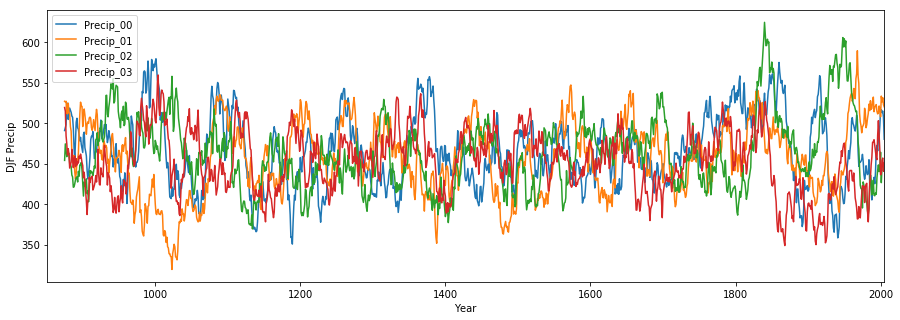

In [9]:
rain_data = pd.read_csv("data/train_precip.csv", index_col="Year")
rain_data.rolling(25).mean().plot(figsize=(15, 5))
plt.ylabel("DJF Precip")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002BBC97E80F0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002BBC984A080>]], dtype=object)

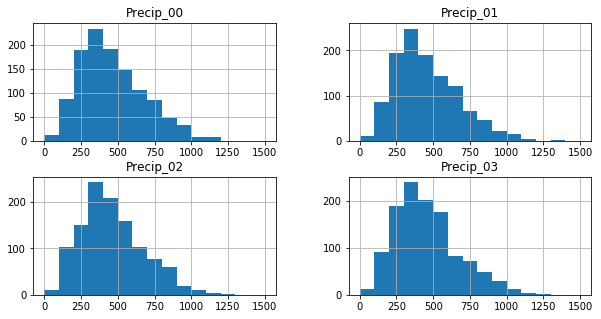

In [10]:
rain_data.hist(bins=np.arange(0, 1600, 100), figsize=(10, 5))

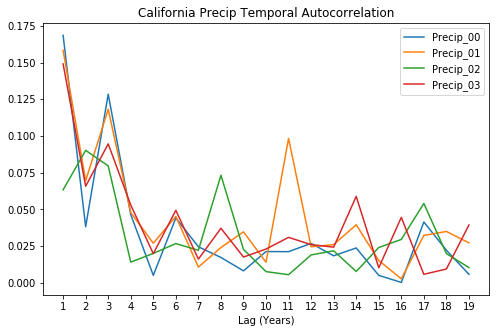

In [11]:
lags = np.arange(1, 20)
autocorr = np.zeros((rain_data.columns.size, lags.size))
plt.figure(figsize=(8, 5))
for c, col in enumerate(rain_data.columns):
    autocorr[c] = np.array([rain_data[col].autocorr(l) for l in range(1, 20)])
    plt.plot(lags, np.abs(autocorr[c]), label=col)
plt.xticks(lags)
plt.title("California Precip Temporal Autocorrelation")
plt.xlabel("Lag (Years)")
plt.legend(loc=0)

## Cross-Validation
For this contest, the cross-validation will take advantage of the relative independence of the different ensemble members. The cross-validation object trains on data from the 3 training ensemble members and tests on the fourth. A separate public testing dataset consists of 4 other ensemble members.

## The Pipeline
The machine learning pipeline for this constest consists of two components: the feature extractor and the classifier. The feature extractor transforms the spatial fields into a flat table that can be processed by scikit-learn-style machine learning and statistical models. The classifier predicts the probability of 750 mm or greater DJF rainfall. 

The starting kit feature extractor spatially normalizes the data and the performs Prinicpal Component Analysis on each variable, keeping the top 20 components. 

In [30]:
class FeatureExtractor():
    def __init__(self):
        self.means = {}
        self.sds = {}
        self.variables = ["TS", "PSL", "TMQ"]
        self.pca = {}
        self.num_comps = 20

    def fit(self, X_ds, y):
        for var in self.variables:
            if var not in self.means.keys():
                self.means[var] = X_ds[var].mean(axis=0).values.astype(np.float32)
                self.sds[var] = X_ds[var].std(axis=0).values.astype(np.float32)
                self.sds[var][self.sds[var] == 0] = 1
            var_norm = (X_ds[var] - self.means[var]) / self.sds[var]
            var_flat = var_norm.stack(latlon=("lat", "lon")).values
            del var_norm
            var_flat[np.isnan(var_flat)] = 0
            self.pca[var] = PCA(n_components=self.num_comps)
            self.pca[var].fit(var_flat)
            del var_flat

    def transform(self, X_ds):
        X = np.zeros((np.prod(X_ds[self.variables[0]].shape[:1]), 
                      self.num_comps * len(self.variables)), dtype=np.float32)
        c = 0
        for var in self.variables:
            var_norm = (X_ds[var] - self.means[var]) / self.sds[var]
            var_flat = var_norm.stack(latlon=("lat", "lon")).values
            del var_norm
            var_flat[np.isnan(var_flat)] = 0
            X[:, c:c+self.num_comps] = self.pca[var].transform(var_flat)
            c += self.num_comps
            del var_flat
        return X

The classifier applies a logistic regression with L1 (LASSO) regularization to the principal component data. L1 regularization results in sparse coeffients, which means that most coefficients will be set to 0. It is a way to perform implicit feature selection with a linear model without having to evaluate a large combination of input variables as in stepwise forward selection. The C parameter controls the strength of the regularization. A smaller value results in fewer non-zero coefficients while a large value leads to more non-zero coefficients. 

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = LogisticRegression(C=0.01, penalty="l1")

    def fit(self, X, y): 
        self.clf.fit(X, y)

    def predict_proba(self, X): 
        return self.clf.predict_proba(X)

In [54]:
fe = FeatureExtractor()
fe.fit(train_X, train_y)
X = fe.transform(train_X)
cls = Classifier()
cls.fit(X, train_y)

In [55]:
from sklearn.linear_model import LinearRegression

In [56]:
xtt=fe.transform(X_test)

In [58]:
cls.clf.score(X,train_y)

0.89177489177489178

In [62]:
cls.clf.score(xtt,y_test)

0.90281385281385285

In [76]:
score_train = score_function(train_y[train_is], cls.clf.predict(X)[train_is])
print(score_train)

-0.0858227768324


## Model Interpretation
In addition to predictive accuracy and reliability, statistical and machine learning models should also have some amount of interpretability. Linear regresssion models can be interpreted based on the magnitude of their coefficents. The plot below shows the principal component loadings associated with the top coefficients.

In [ ]:
coefs = cls.clf.coef_[0]
coef_rankings = np.argsort(np.abs(coefs))[::-1]
fig, axes = plt.subplots(3, 3, figsize=(16, 9), 
                         subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
axef = axes.ravel()
for c, coef_rank in enumerate(coef_rankings[:9]):
    c_var = data_vars[int(np.floor(coef_rank / fe.num_comps))]
    c_comp = coef_rank % fe.num_comps
    comp_vals = fe.pca[c_var].components_[c_comp]
    axef[c].coastlines()
    axef[c].contourf(train_X["lon"] - 180, 
                     train_X["lat"], 
                     fe.pca[c_var].components_[c_comp].reshape(train_X[c_var].shape[1:]),
                     np.linspace(-0.04, 0.04, 11), cmap="RdBu_r")
    axef[c].set_title("{0} Comp {1:d} Coef: {2:0.4f}".format(c_var, c_comp, coefs[coef_rank]))

## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/starting_kit).

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `ts_feature_extractor.py` and  `classifier.py` are in the  [`submissions/starting_kit`](/tree/submissions/starting_kit) folder, and the data `train_*.nc` and `test_*.nc` are in [`data`](/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [ ]:
!source activate ramp_ci_2017; ramp_test_submission

## Experimenting within the Notebook
When you are developing and debugging your submission, you may want to stay in the notebook and execute the workflow step by step. You can import `problem.py` and call the ingredients directly below.

In [17]:
import imp
problem = imp.load_source('', 'problem.py')

In [22]:
X_train, y_train = problem.get_train_data()

In [29]:
X_train.keys()#["TS"]

KeysView(<xarray.Dataset>
Dimensions:  (enstime: 4620, lat: 96, lon: 144)
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 -78.63 ...
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * enstime  (enstime) MultiIndex
  - ens      (enstime) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
  - time     (enstime) float64 334.0 699.0 1.064e+03 1.429e+03 1.794e+03 ...
Data variables:
    TS       (enstime, lat, lon) float32 229.816 230.559 229.816 229.816 ...
    PSL      (enstime, lat, lon) float32 99116.7 99116.7 99116.7 99116.7 ...
    TMQ      (enstime, lat, lon) float32 0.596768 0.596768 0.596768 0.596768 ...
    U_500    (enstime, lat, lon) float32 2.61272 2.61272 2.84498 2.84498 ...
    V_500    (enstime, lat, lon) float32 -2.1523 -2.00191 -1.85153 -1.70114 ...)

In [41]:
train_is, test_is = list(problem.get_cv(X_train, y_train))[0]
print(len(train_is), len(test_is))

3465 1155


In [51]:
np.sum(y_train)/float(len(y_train))

0.11103896103896103

In [102]:
ts_fe, reg = problem.workflow.train_submission(
    'submissions/starting_kit', X_train, y_train, )#train_is)

In [103]:
y_pred = problem.workflow.test_submission((ts_fe, reg), X_train)

In [104]:
score_function = problem.score_types[0]

In [83]:
xtr=ts_fe.fit(X_train,train_y)

In [86]:
xtr=ts_fe.transform(X_train)
xtt=ts_fe.transform(X_test)

In [85]:
from sklearn.svm import LinearSVC

In [87]:
c=LinearSVC()

In [ ]:
y_pred=

In [88]:
c.fit(xtr,train_y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [200]:
y_train.shape

(4620,)

In [97]:
y_pred2=c.decision_function(xtr)

In [100]:
y_pred2=(y_pred2-np.min(y_pred2))/(np.max(y_pred2)-np.min(y_pred2))

In [107]:
score_train = score_function(y_train[train_is],y_pred[:,1][train_is])# y_pred[train_is][:, 1])
print(score_train)

0.156941727186


In [113]:
y_test_pred[:,0]

array([ 0.79215219,  0.70518437,  0.7946811 , ...,  0.93613449,
        0.76785571,  0.76664413])

In [169]:
xtr=ts_fe.transform(X_train)

In [170]:
reg.predict_proba(xtr)[:,1]

array([ 0.10289577,  0.05855541,  0.02216399, ...,  0.04657057,
        0.01691343,  0.04362632])

In [171]:
reg.clf

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [182]:
c=LinearSVC()

In [199]:
# Create the model
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.matmul(x, W) + b


In [ ]:
# Create the model
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.matmul(x, W) + b

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])

# The raw formulation of cross-entropy,
#
#   tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.nn.softmax(y)),
#                                 reduction_indices=[1]))
#
# can be numerically unstable.
#
# So here we use tf.nn.softmax_cross_entropy_with_logits on the raw
# outputs of 'y', and then average across the batch.
cross_entropy = tf.reduce_mean(
  tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
# Train
for _ in range(1000):
batch_xs, batch_ys = mnist.train.next_batch(100)
sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

# Test trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images,
                                  y_: mnist.test.labels}))

In [183]:
c.fit(xtr,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [173]:
p1=c.predict_proba(xtr)

In [184]:
p1=c.decision_function(xtr)

In [185]:
p1=(p1-np.min(p1))/(np.max(p1)-np.min(p1))

In [186]:
p2=1-p1

In [189]:
y_pred=np.array([p1,p2]).T

In [190]:
y_pred.shape

(4620, 2)

In [193]:
score_valid = score_function(y_train[train_is], y_pred[train_is][:, 0])



In [194]:
score_valid

-0.71300404568907272

In [109]:
X_test, y_test = problem.get_test_data(path="./")

In [110]:
y_test_pred = problem.workflow.test_submission((ts_fe, reg), X_test)

In [111]:
score_test = score_function(y_test, y_test_pred[:, 1])
print(score_test)

0.113929922922


## Hackathon Ideas
Struggling to come up with an idea for the hackathon? Try some of these ideas.

* Perform PCA on different sub-regions of the data to extract specific teleconnections, such as ENSO or PDO.
* Replace the LogisticRegression with a RandomForestClassifier or a GradientBoostingClassifier.
* Add the U_500 and V_500 variables to the starting kit model.
* Try a different dimensionality reduction technique.
* Ensemble multiple classifiers together.
* Experiment with different transformations of the input variables.
* Apply image processing methods to identify potential features of interest.

## Group Presentations
At the end of the Hackathon, we would like each group to prepare a short presentation about their forecast model and what they learned from it. Please include the following information:
* Description of the feature extractor
* Description of the machine learning model
* Scores on train/validation/test data
* Interpretation of features learned by model
* Challenges and insights from your Hackathon experience